# 1. Simulation

This part is a discrete simulation of a gas diffusion in a open area.
The gaz is continuously released from a source and diffuses in the area.

## 1.1. Fick diffusion

Import necessary libraries

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import scipy as sp
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from itertools import combinations_with_replacement
from multiprocessing import Pool, cpu_count
from collections import defaultdict
import pandas
from scipy.optimize import minimize
import itertools

Define a builder class to create the simulation environment

In [53]:
class FickDiffusionBuilder():

    def __init__(self):
        self.size = (20, 20)

        self.points = (100, 100)
        
        self.source_rate = 10
        
        self.source_position = np.array([5, 10])
        
        self.dt = 0.1
        
        self.D = 1

    def set_size(self, size):
        """
        Set the size of the grid in meters

        Parameters:

        size : tuple
            The size of the grid in meters (x, y)
        """
        self.size = size
        return self

    def set_points(self, points):
        """
        Set the number of points in the grid in each dimension (grid resolution)

        Parameters:
        
        points : tuple
            The number of points in the grid in each dimension (x, y)
        """
     
        self.points = points
        return self

    def set_source_rate(self, source_rate):
        """
        Set the source rate of the particles in particles per second

        Parameters:

        source_rate : float
            The source rate of the particles in particles per second        
        """

        self.source_rate = source_rate
        return self
    
    def set_source_position(self, source_position):
        """
        Set the position of the source in the grid

        Parameters:

        - source_position (numpy.ndarray of shape (2,)) : The position of the source in the grid in meters
        """

        self.source_position = source_position
        return self

    def set_time_step(self, dt):
        """
        Set the time step of the simulation in seconds

        Parameters:

        dt : float
            The time step of the simulation in seconds
        """
        
        self.dt = dt
        return self

    def set_diffusion_coefficient(self, D):
        """
        Set the diffusion coefficient of the particles in the medium in m^2/s

        Parameters:

        D : float
            The diffusion coefficient of the particles in the medium
        """
        
        self.D = D
        return self

    def build(self):
        """
        Build the FickDiffusion object with the specified parameters

        Returns:

        FickDiffusion
            The FickDiffusion object with the specified parameters
        """

        return FickDiffusion(self.size, self.points, self.source_rate, self.source_position, self.dt, self.D)

Simulate gas diffusion in a plane following Fick's 2nd law of diffusion :

$$
\frac{\delta C}{\delta t} = D \nabla^2 C
$$

where $C$ is the concentration of the gas, $D$ is the diffusion coefficient and $\nabla^2 C$ is the Laplacian operator : 

$$
\nabla^2 C = \frac{\delta^2 C}{\delta x^2} + \frac{\delta^2 C}{\delta y^2}
$$

Using the finite difference method, we can approximate the Laplacian operator as follows :

$$
\frac{\delta^2 C}{\delta x^2} \approx \frac{C_{i+1,j} - 2C_{i,j} + C_{i-1,j}}{\Delta x^2}
$$

$$
\frac{\delta^2 C}{\delta y^2} \approx \frac{C_{i,j+1} - 2C_{i,j} + C_{i,j-1}}{\Delta y^2}
$$

where $\Delta x$ and $\Delta y$ are the steps in the $x$ and $y$ directions.


In [54]:
def diffuse(C, D, dt, dx, dy):
    """
    Diffuse the gas in the area using the Fick's second law of diffusion

    # Parameters:

    - C (numpy.ndarray): The concentration matrix of the gas in the area
    - D (float): The diffusion coefficient of the gas in the medium
    - dt (float): The time step of the simulation in seconds
    - dx (float): The distance between two points in the x direction in meters
    - dy (float): The distance between two points in the y direction in meters
    
    Returns:

    numpy.ndarray
        The reference of concentration matrix of the gas in the area after diffusion (this is not a copy)
    """

    # Laplacian of C
    d2C_dx2 = (np.roll(C, 1, axis=0) - 2 * C + np.roll(C, -1, axis=0)) / dx**2
    d2C_dy2 = (np.roll(C, 1, axis=1) - 2 * C + np.roll(C, -1, axis=1)) / dy**2
    # We use np.roll since it is faster than for loops

    # Diffusion equation
    dC_dt = D * (d2C_dx2 + d2C_dy2)
        
    # Time integration
    C += dt * dC_dt
        
    # Boundary conditions (necessary in order to use np.roll + simulate an open area)
    C[0, :] = 0
    C[-1, :] = 0
    C[:, 0] = 0
    C[:, -1] = 0

    return C

Since our simulation is dealing with partial differential equations, we need to use a numerical method to solve it. We will use the finite difference method to solve the diffusion equation. However we have to ensure the stability of calculation by respecting the Courant-Friedrichs-Lewy (CFL) condition :

$$
\frac{D \Delta t}{\Delta x^2} + \frac{D \Delta t}{\Delta y^2} \leq \frac{1}{2}
$$

where $\Delta t$ is the time step and $D$ is the diffusion coefficient.


In [55]:
def get_courant_friedrichs_lewy_coefficient(D, dt, dx, dy):
    """
    Get the Courant-Friedrichs-Lewy (CFL) coefficient for the simulation

    # Parameters:

    - D (float): The diffusion coefficient of the gas in the medium in m^2/s
    - dt (float): The time step of the simulation in seconds
    - dx (float): The distance between two points in the x direction in meters
    - dy (float): The distance between two points in the y direction in meters
    
    # Returns:
    float : The Courant-Friedrichs-Lewy (CFL) coefficient for the simulation
    """
    
    return ((D * dt) / (dx**2)) + ((D * dt) / (dy**2))

Since we will diffuse the gaz at a single point in the area at a constant rate, we have the simple function :

In [56]:
def release_gaz(C, source_coordinates, source_rate):
    """
    Release gas from a source in the area

    # Parameters:

    - C (numpy.ndarray) : The concentration matrix of the gas in the area
    - source_coordinates (numpy.ndarray) : The coordinates of the source in the area (x, y)
    - source_rate (float) : The rate of the gas released from the source in particles per second
    Returns:

    - numpy.ndarray : The reference of concentration matrix of the gas in the area after releasing gas from the source (this is not a copy)
    """

    C[source_coordinates[0], source_coordinates[1]] = source_rate
    return C

Here is the wrapping class that will simulate the gas diffusion in the area.

In [57]:
class FickDiffusion():
    def __init__(self, size, points, source_rate, source_position, dt, D):
        # Size of the area
        self.length = size[0]
        self.width = size[1]
    
        # Number of grid points
        self.nx = points[0]
        self.ny = points[1]

        # Grid spacing
        self.dx = self.length / self.nx
        self.dy = self.width / self.ny
        
        # Time step
        self.dt = dt

        # Gas diffusion coefficient
        self.D = D * dt

        # Check the Courant-Friedrichs-Lewy stability condition
        courant_friedrichs_lewy = get_courant_friedrichs_lewy_coefficient(self.D, self.dt, self.dx, self.dy)

        if courant_friedrichs_lewy > 0.5:
            raise ValueError(f"Courant-Friedrichs-Lewy condition not met ({courant_friedrichs_lewy} > 0.5), please reduce the time step or increase the grid resolution")
        
        # Source release rate
        self.source_rate = source_rate * self.dt
       
        # Source location (offset from the center)
        self.source_coordinates = self.get_grid_coordinates(source_position)


    def get_grid_coordinates(self, real_coordinates):
        """
        Convert the real-world coordinates to grid coordinates

        Parameters:
        - coordinates (numpy.ndarray of shape (n, 2)): the real-world coordinates to convert

        Returns:
        - coordinates (numpy.ndarray of shape (n, 2)): the grid coordinates
        """

        if not isinstance(real_coordinates, np.ndarray):
            raise ValueError("The coordinates should be a tuple or a numpy.ndarray")


        if len(real_coordinates.shape) == 1:
            real_coordinates = real_coordinates.reshape(1, 2)
                
        coordinates = np.zeros_like(real_coordinates, dtype=int)
        coordinates[:, 0] = real_coordinates[:, 0] // self.dx
        coordinates[:, 1] = real_coordinates[:, 1] // self.dy

        if len(coordinates) == 1:
            coordinates = coordinates.flatten()

        return coordinates

    def animate(self, final_time, source_start=0, source_end=None):
        """
        Animate the diffusion of gas in the area for a given time
        and return the animation object

        Parameters:
        - final_time: the final time of the simulation
        - source_start: the time at which the source starts releasing gas
        - source_end: the time at which the source stops releasing gas

        Returns:
        - ani: the animation object
        """

        # Initialize the concentration matrix
        C = np.zeros((self.nx, self.ny))
        C = release_gaz(C, self.source_coordinates, self.source_rate)

        # If the source end is not specified, we assume that the source will release gas until the end of the simulation
        if source_end is None:
            source_end = final_time

        # Create the figure and axis
        fig, ax = plt.subplots()
        im = ax.imshow(C, cmap='hot', interpolation='nearest', animated=True)   
        text_label = ax.text(0.5, 1.01, '', transform=ax.transAxes, ha="center", va="bottom")
        
        times = np.arange(0, final_time, self.dt)

        def animation_function(params):
            i, t = params

            """
            Animation callback function that updates the concentration of gas in the area.
            """
            nonlocal C
    
            # Simulate the diffusion of gas in the area
            C = self.release_and_diffuse(C, t, source_start, source_end)

            # Update the image and text label
            im.set_array(C)
            text_label.set_text(f"Frame {i} - Time {t:.2f} s")

            return im,
            
        ani = animation.FuncAnimation(fig, animation_function, frames=enumerate(times), interval=int(self.dt*1000), blit=True)
        return ani

    def simulate(self, final_time, sensors_coordinates, source_start=0, source_end=None):
        """
        Simulate the diffusion of gas in the area for a given time
        and return the pseudo-sensor data for the given pseudo-sensors coordinates

        Parameters:
        - final_time: the final time of the simulation
        - sensors_coordinates (numpy.ndarray of shape (n, 2)): the real-world coordinates of the pseudo-sensors
        - source_start: the time at which the source starts releasing gas
        - source_end: the time at which the source stops releasing gas

        Returns:
        - x: the x coordinates of the pseudo-sensors
        - y: the y coordinates of the pseudo-sensors
        - time: the time of the simulation
        - values: the concentration values at the pseudo-sensors
        """

        # Initialize the concentration matrix
        C = self.create_concentration_matrix()

        times = np.arange(0, final_time, self.dt)


        # Convert the real-world coordinates to grid coordinates
#        grid_coordinates = self.get_grid_coordinates(sensors_coordinates)


        # Create the different matrices to store the data
        sensors = []

        for coordinates in sensors_coordinates:
            sensors.append({
                "real_coordinates": coordinates,
                "grid_coordinates": self.get_grid_coordinates(coordinates),
                "data": pandas.DataFrame({
                    "time": times,
                    "value": np.zeros_like(times)
                })
            })
        
        # If the source end is not specified, we assume that the source will release gas until the end of the simulation
        if source_end is None:
            source_end = final_time
            

        # Iterate over the time steps
        for i, t in enumerate(times):
            # Simulate the diffusion of gas in the area
            C = self.release_and_diffuse(C, t, source_start, source_end)

            # Collect the pseudo-sensor data
            for sensor in sensors:
                sensor["data"].loc[i, "value"] = C[sensor["grid_coordinates"][0], sensor["grid_coordinates"][1]]

        return sensors
        
    def release_and_diffuse(self, C, t, source_start, source_end):
        """
        Simulate the diffusion of gas in the area for a given time
        and return the concentration matrix

        Parameters:
        - C: the concentration matrix
        - t: the current time
        - source_start: the time at which the source starts releasing gas
        - source_end: the time at which the source stops releasing gas

        Returns:
        - C: the concentration matrix
        """

        # Release gas if the time is within the source start and end time
        if t >= source_start and t <= source_end:
            release_gaz(C, self.source_coordinates, self.source_rate)

        # Diffuse the gas in the area
        C = diffuse(C, self.D, self.dt, self.dx, self.dy)

        return C

    def create_concentration_matrix(self):
        """
        Create the concentration matrix

        Returns:
        - C: the concentration matrix
        """
        C = np.zeros((self.nx, self.ny))
        return C

    def get_current_time(self, i):
        """
        Get the current time of the simulation given the iteration i

        Parameters:
        - i: the current iteration

        Returns:
        - t: the current time
        """
        return i * self.dt

## 1.2. Animation

Perform a simulation of gas diffusion in a 2D area and display the result as an animation.

/tmp/ipykernel_71624/27249947.py:107: UserWarning: frames=<enumerate object at 0x7fd292accc20> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, animation_function, frames=enumerate(times), interval=int(self.dt*1000), blit=True)


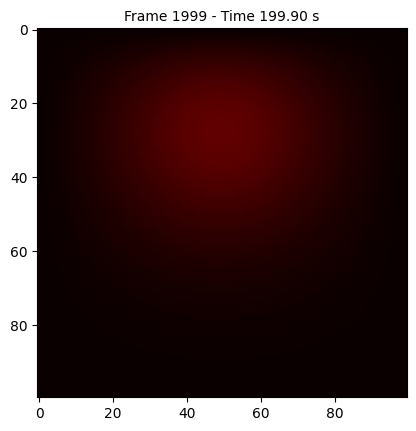

In [58]:
ani = (FickDiffusionBuilder()
    .build()
    .animate(200, source_end=150))

HTML(ani.to_html5_video())


## 1.3. Concentration behavior

Values shape: (29, 4000)

Times shape: (29, 4000)

Values log shape: [[0.         0.         0.125      ... 0.38499818 0.3850105  0.38452452]
 [0.         0.         0.125      ... 0.39415174 0.39416575 0.39368898]
 [0.         0.         0.         ... 0.39566535 0.39568058 0.39522345]
 ...
 [0.         0.         0.         ... 0.05098213 0.05099756 0.05099755]
 [0.         0.         0.         ... 0.03549552 0.03550653 0.03550653]
 [0.         0.         0.         ... 0.02528962 0.02529755 0.02529755]]

Values log shape: (29, 4000)

Values log: (29,)



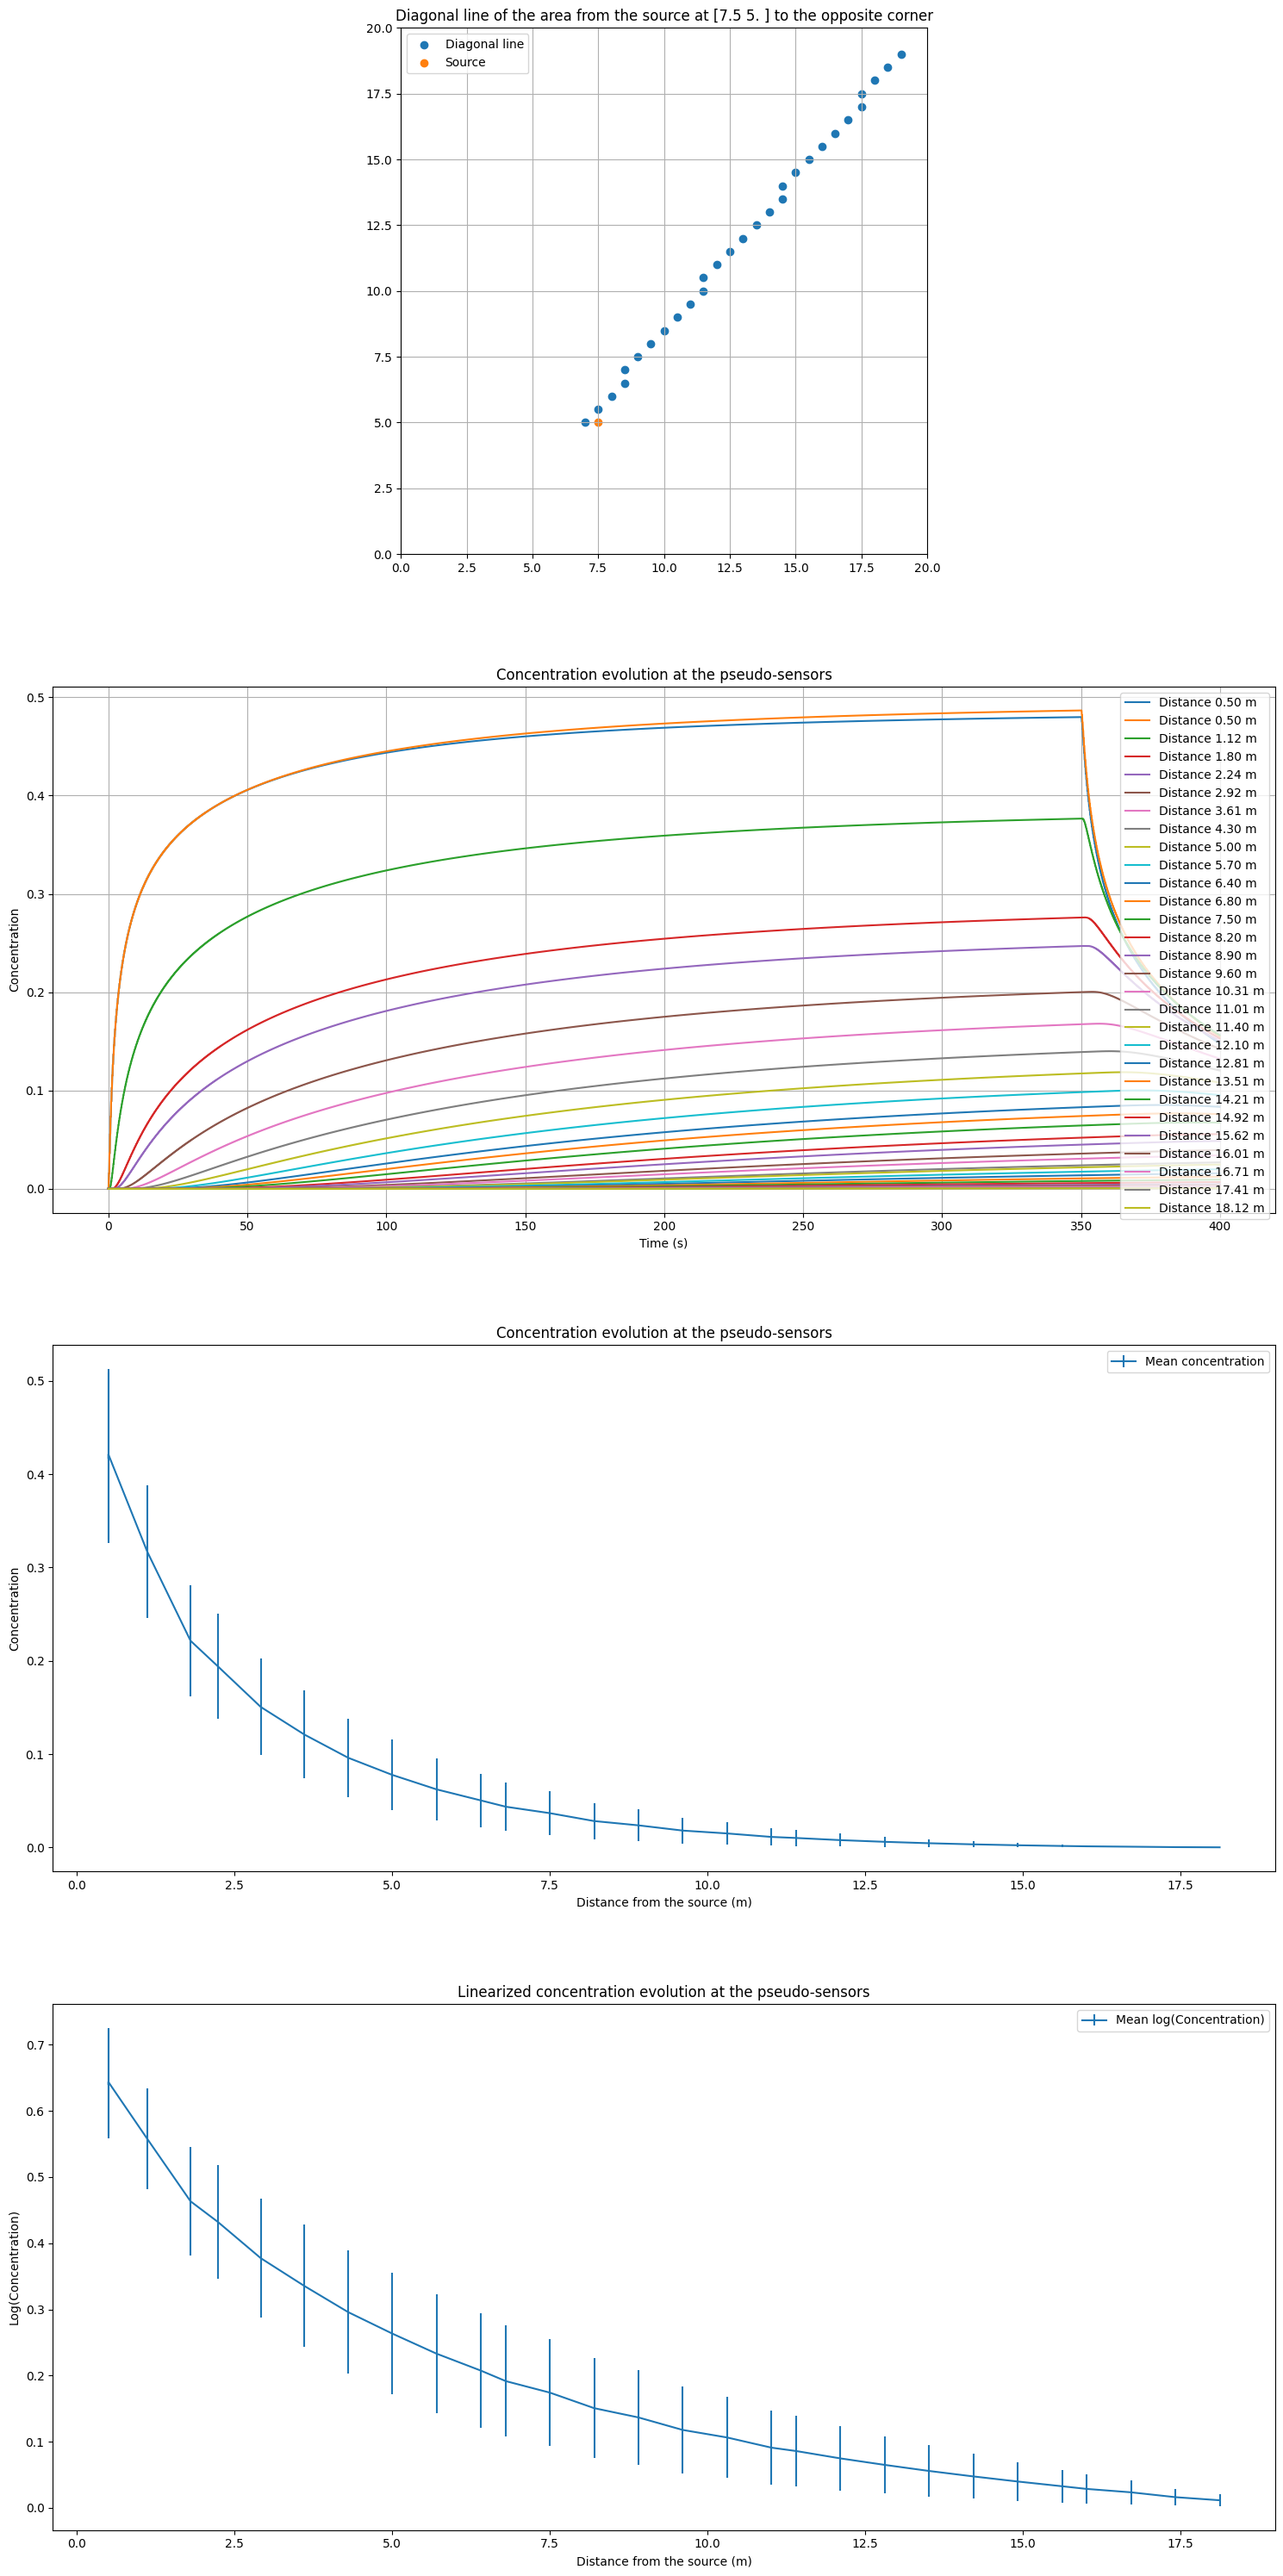

In [59]:
def bresenham_line(start_coordinates, end_coordinates, increment=1):
    """
    Bresenham's line algorithm
    
    Parameters:
    - start_coordinates (tuple of 2 floats): the start coordinates of the line
    - end_coordinates (tuple of 2 floats): the end coordinates of the line
    - increment (positive float): the increment of the line, the input coordinates should be multiples of the increment.

    Returns:
    - numpy.ndarray: the coordinates of the line's points
    """

    x0, y0 = start_coordinates
    x1, y1 = end_coordinates

    # Check if the coordinates are multiples of the increment to avoid the algorithm to loop indefinitely and eat all the memory
    if x0 % increment != 0 or y0 % increment != 0 or x1 % increment != 0 or y1 % increment != 0:
        raise ValueError("The coordinates should be multiples of the increment")

    points = []
    dx = abs(x1 - x0)
    dy = -abs(y1 - y0)
    sx = increment if x0 < x1 else -increment
    sy = increment if y0 < y1 else -increment
    err = dx + dy 

    while True:
        points.append((x0, y0))

        if x0 == x1 and y0 == y1:
            break
               
        e2 = 2 * err
        if e2 >= dy:  
            err += dy
            x0 += sx
        if e2 <= dx:  
            err += dx
            y0 += sy
            
    return np.array(points)

def get_diagonal_line(source_position, size, increment=1):
    """
    Get the diagonal line of the area (from the source to the opposite corner of the area using Bresenham's algorithm)

    Returns:
    - diagonal: the diagonal line
    """  

    x_0 = int(source_position[0])
    y_0 = int(source_position[1])

    size_x = int(size[0])
    size_y = int(size[1])

    # We want to find the map edges that are the furthest from the source
    if x_0 > size_x - x_0:
        x_1 = 0
    else:
        x_1 = size_x - 1

    if y_0 > size_y - y_0:
        y_1 = 0
    else:
        y_1 = size_y - 1

    # Compute the diagonal line using Bresenham's algorithm 
    return bresenham_line((x_0, y_0), (x_1, y_1), increment)

def show_concentration_evolution():
    # Show the diagonal line of the area from the source to the opposite corner
    source_position = np.array([7.5, 5])
    size = (20, 20)
    diagonal = get_diagonal_line(source_position, size, increment=0.5)

    figure, axes = plt.subplots(4, 1, figsize=(15, 30))

    # Plot the diagonal line
    axes[0].scatter(diagonal[:, 0], diagonal[:, 1], label="Diagonal line")
    axes[0].scatter(source_position[0], source_position[1], label="Source")
    axes[0].set_title(f"Diagonal line of the area from the source at {source_position} to the opposite corner")
    axes[0].set_xlim(0, size[0])
    axes[0].set_ylim(0, size[1])
    axes[0].legend()
    axes[0].grid()
    axes[0].set_aspect('equal')

    # Simulate the diffusion of gas in the area and collect the pseudo-sensor data
    sensors = (FickDiffusionBuilder()
            .set_source_position(source_position)
            .build()
            .simulate(400, sensors_coordinates=diagonal, source_end=350))

    values = np.array([sensor["data"]["value"] for sensor in sensors])
    times = np.array([sensor["data"]["time"] for sensor in sensors])

    print(f"Values shape: {values.shape}\n")
    print(f"Times shape: {times.shape}\n")

    positions = [sensor["real_coordinates"] for sensor in sensors]
    distances = [np.linalg.norm(source_position - position) for position in positions]


    axes[1].set_title("Concentration evolution at the pseudo-sensors")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Concentration")
    for v, t, d in zip(values, times, distances):
        axes[1].plot(t, v, label=f"Distance {d:.2f} m")
    axes[1].legend()
    axes[1].grid()

    # Plot the concentration evolution at the pseudo-sensors

    axes[2].set_title("Concentration evolution at the pseudo-sensors")
    axes[2].set_xlabel("Distance from the source (m)")
    axes[2].set_ylabel("Concentration")
    axes[2].errorbar(distances, values.mean(axis=1), yerr=values.std(axis=1), label="Mean concentration")
    axes[2].legend()

    values_log = np.sqrt(values)

    print(f"Values log shape: {values_log}\n")

    print(f"Values log shape: {values_log.shape}\n")

    print(f"Values log: {values_log.mean(axis=1).shape}\n")

    axes[3].set_title("Linearized concentration evolution at the pseudo-sensors")
    axes[3].set_xlabel("Distance from the source (m)")
    axes[3].set_ylabel("Log(Concentration)")
    axes[3].errorbar(distances, values_log.mean(axis=1), yerr=values_log.std(axis=1), label="Mean log(Concentration)")
    axes[3].legend()
    


    figure.tight_layout()


show_concentration_evolution()




## 1.3. Simulation

Let's simulate the gas diffusion in a 2D area with pseudo-sensor.

Since the simulation generate data for sensors that actually never receive the gaz, we will remove them from the exported dataset.

In [60]:
def filter_sensors(values):
    """
    Filter the sensors data by removing the sensors that have a constant value
    """
    return np.where(np.std(values, axis=1) > 0.01)

Since we want to run the simulation in a parallel way, we write a worker function that will simulate the gas diffusion in a 2D area and return the result as a list of dictionaries.

In [61]:
def simulate_environment(source_coordinates, D, environment_index, sensors_coordinates):
    """
    Simulate the environment with a source at the given coordinates and diffusion coefficient

    Parameters:
    - source_coordinates (numpy.ndarray of shape (2,)): the real-world coordinates of the source
    - D (float): the diffusion coefficient of the gas in the medium
    - environment_index (int): the index of the environment
    - sensors_coordinates (numpy.ndarray of shape (n, 2)): the real-world coordinates of the pseudo-sensors

    Returns:
    - dict: the data of the environment in a dictionary format
    """

    print(f"Simulating source at {source_coordinates} with D={D}\n")

    fick_diffusion = (FickDiffusionBuilder()
        .set_source_position(source_coordinates)
        .set_diffusion_coefficient(D)
        .build())

    # - Simulate 
    sensors = fick_diffusion.simulate(400, sensors_coordinates=sensors_coordinates, source_end=350)

    # - Filter the sensors that have a constant value
    # valid_index = filter_sensors(value)

    # value = value[valid_index]
    # x = x[valid_index]
    # y = y[valid_index]
    # time = time[valid_index]

    # - Reshape 
    # signal_identifier = np.arange(value.shape[0]).repeat(value.shape[1]).reshape(value.shape)
    
#    environment_identifier = np.ones_like(signal_identifier) * environment_index

#    D = np.ones_like(value) * D

    # sources_coordinates_x = np.ones_like(value) * source_coordinates[0]
    # sources_coordinates_y = np.ones_like(value) * source_coordinates[1]

    # - Return the data in a dictionary format for better handling        
    return {
        "environment_identifier": environment_index,
        "diffusion_coefficient": D,
        "source_coordinates": source_coordinates,
        "sensors": sensors
    }
    
    


Since one dictionary is generated for each environment by the worker function, we will merge the list of dictionaries into a single dictionary.

In [62]:
def merge_list_of_dictionaries_into_dataframe(list_of_dictionaries):
    """
    Merge a list of dictionaries into a single dictionary

    Parameters:
    - list_of_dictionaries (list): the list of dictionaries to merge into a single dictionary

    Returns:
    - pandas.DataFrame: the merged dictionary as a pandas DataFrame
    """

    merged_dictionary = defaultdict(list)

    for dictionary in list_of_dictionaries:
        for key, value in dictionary.items():
            merged_dictionary[key].append(value)

    for key, value in merged_dictionary.items():
        merged_dictionary[key] = np.concatenate(value).flatten()


    return pd.DataFrame(merged_dictionary)

Let's generate for multiple diffusion coefficients $D$ and source positions $(x_s, y_s)$ and store the results in a HDF5 file.


In [63]:
arguments_list = []
environment_index = 0

sensors_coordinates = np.array([
    [2.0, 2.0],
    [2.0, 18.0],
    [17.0, 2.0],
    [15.0, 15.0]
])

# - Prepare the arguments list for the simulation with different environments (source positions and diffusion coefficients)
for source_coordinates in combinations_with_replacement(np.linspace(5, 15, 5), 2):
    source_coordinates = np.array(source_coordinates)
    for D in np.linspace(0.1, 1, 10):
        # Add the arguments to the list
        arguments_list.append((source_coordinates, D, environment_index, sensors_coordinates))
      
        environment_index += 1


print(f"Simulating {len(arguments_list)} environments")

# - Simulate the environments in parallel using all the available CPUs cores
with Pool(cpu_count()) as pool:
    raw_training_data = pool.starmap(simulate_environment, arguments_list)



Simulating 150 environments
Simulating source at [5. 5.] with D=0.1
Simulating source at [5. 5.] with D=0.5
Simulating source at [5. 5.] with D=0.30000000000000004
Simulating source at [5. 5.] with D=0.7000000000000001
Simulating source at [5.  7.5] with D=0.7000000000000001
Simulating source at [5. 5.] with D=0.9
Simulating source at [5.  7.5] with D=0.1
Simulating source at [5.  7.5] with D=0.30000000000000004
Simulating source at [ 5. 10.] with D=0.5
Simulating source at [ 5. 10.] with D=0.30000000000000004
Simulating source at [ 5. 10.] with D=0.1
Simulating source at [ 5. 10.] with D=0.7000000000000001
Simulating source at [5.  7.5] with D=0.5
Simulating source at [ 5. 10.] with D=0.9
Simulating source at [5.  7.5] with D=0.9
Simulating source at [ 5.  12.5] with D=0.30000000000000004
Simulating source at [ 5.  12.5] with D=0.5
Simulating source at [ 5.  12.5] with D=0.7000000000000001


Simulating source at [ 5.  12.5] with D=0.1





Simulating source at [ 5.  12.5] with D=0.9



In [224]:
def plot_environment(environment, predicted_sources_coordinates=None):
    """
    Plot the environment with the source and the sensors

    Parameters:
    - environment (dict): the environment data
    """

    n = len(environment['sensors'])

    # Create the figure and axis
    fig, ax = plt.subplots(2, 1, figsize=(15, 15))
    ax[0].set_title(f"Source at {environment['source_coordinates']} with D={environment['diffusion_coefficient']}")

    # Plot the source
    ax[0].scatter(*environment['source_coordinates'], cmap='hot', label='Source', marker='$S$')

    # Plot the predicted sources coordinates
    if predicted_sources_coordinates is not None:
        for name, coordinates in predicted_sources_coordinates.items():
            distance = np.linalg.norm(environment['source_coordinates'] - np.array(coordinates))
            label = f"{name} with distance {distance:.2f}"
            ax[0].scatter(*coordinates, label=label, marker='P')


    colors = ['r', 'g', 'b', 'y']
    markers = [f"${i}$" for i in range(1, n + 1)]

    # Plot the sensors
    for sensor, color, marker in zip(environment['sensors'], colors, markers):
        distance = np.linalg.norm(environment['source_coordinates'] - sensor['real_coordinates'])
        ax[0].scatter(*sensor['real_coordinates'], label=f"Sensor - distance {distance:.2f}", color=color, marker=marker)

    ax[0].set_xlabel("X")
    ax[0].set_ylabel("Y")

    # Force ticks to be 1
    ax[0].set_xticks(np.arange(0, 20, 1))
    ax[0].set_yticks(np.arange(0, 20, 1))

    # Set the aspect of the plot to be equal
    ax[0].set_aspect('equal', 'box')
    ax[0].grid()
    ax[0].legend()

    # Plot the sensors data

    ax[1].set_title(f"Sensors data with {len(environment['sensors'][0]['data'])} samples")
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Concentration")
    #ax[1].set_yscale('log')

    for sensor, color, marker in zip(environment['sensors'], colors, markers):
        ax[1].plot(sensor['data']['time'][::40], sensor['data']['value'][::40], label=f"Sensor at {sensor['real_coordinates']}", alpha=0.5, color=color)

    ax[1].legend()

    fig.tight_layout()

    plt.show()

# - Plot the first environment
# plot_environment(current_environment)

In [225]:
def locate_average(positions, weights):
    if np.sum(weights) == 0:
        return np.average(positions, axis=0)

    source_coordinates = np.average(positions, axis=0, weights=weights)

    return source_coordinates.flatten()

In [226]:
def locate_optimization2(positions, values, D, t_c):

    if positions.shape[0] != values.shape[0]:
        raise ValueError("The positions and values should have the same length")

    n = positions.shape[0]

    combinations = list(itertools.permutations(range(values.shape[0]), 2))

    def concentration_prediction(x_1, y_1, x_2, y_2, x_s, y_s, D, t_c, t_0):
        r_1 = np.sqrt((x_1 - x_s)**2 + (y_1 - y_s)**2)
        r_2 = np.sqrt((x_2 - x_s)**2 + (y_2 - y_s)**2)

        t = t_c - t_0

        return np.exp(((r_2**2) - (r_1**2))/(4*D*t))

    def residuals(params, combinations, positions, values, D, t_c):
        x_s, y_s, t_0 = params

        t = t_c - t_0
     
        predicted = []
        real = []

        for i_1, i_2 in combinations:
            
            x_1, y_1 = positions[i_1]
            x_2, y_2 = positions[i_2]

            y = values[i_1] / values[i_2]

            predicted.append(concentration_prediction(x_1, y_1, x_2, y_2, x_s, y_s, D, t_c, t_0))
            real.append(y)

        predicted = np.array(predicted)
        real = np.array(real)

        #print(np.linalg.norm(predicted - real)) 

        return np.sum(np.linalg.norm(predicted - real))

    initial_position = locate_average(positions, np.sqrt(values))

    #print(f'Initial position: {initial_position}')
    
    initial_guess = np.append(initial_position, 0)  # [x_s, y_s, t_0]

    result = minimize(residuals, initial_guess, args=(combinations, positions, values, D, t_c))

    return result.x

/tmp/ipykernel_71624/1936903641.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0].scatter(*environment['source_coordinates'], cmap='hot', label='Source', marker='$S$')


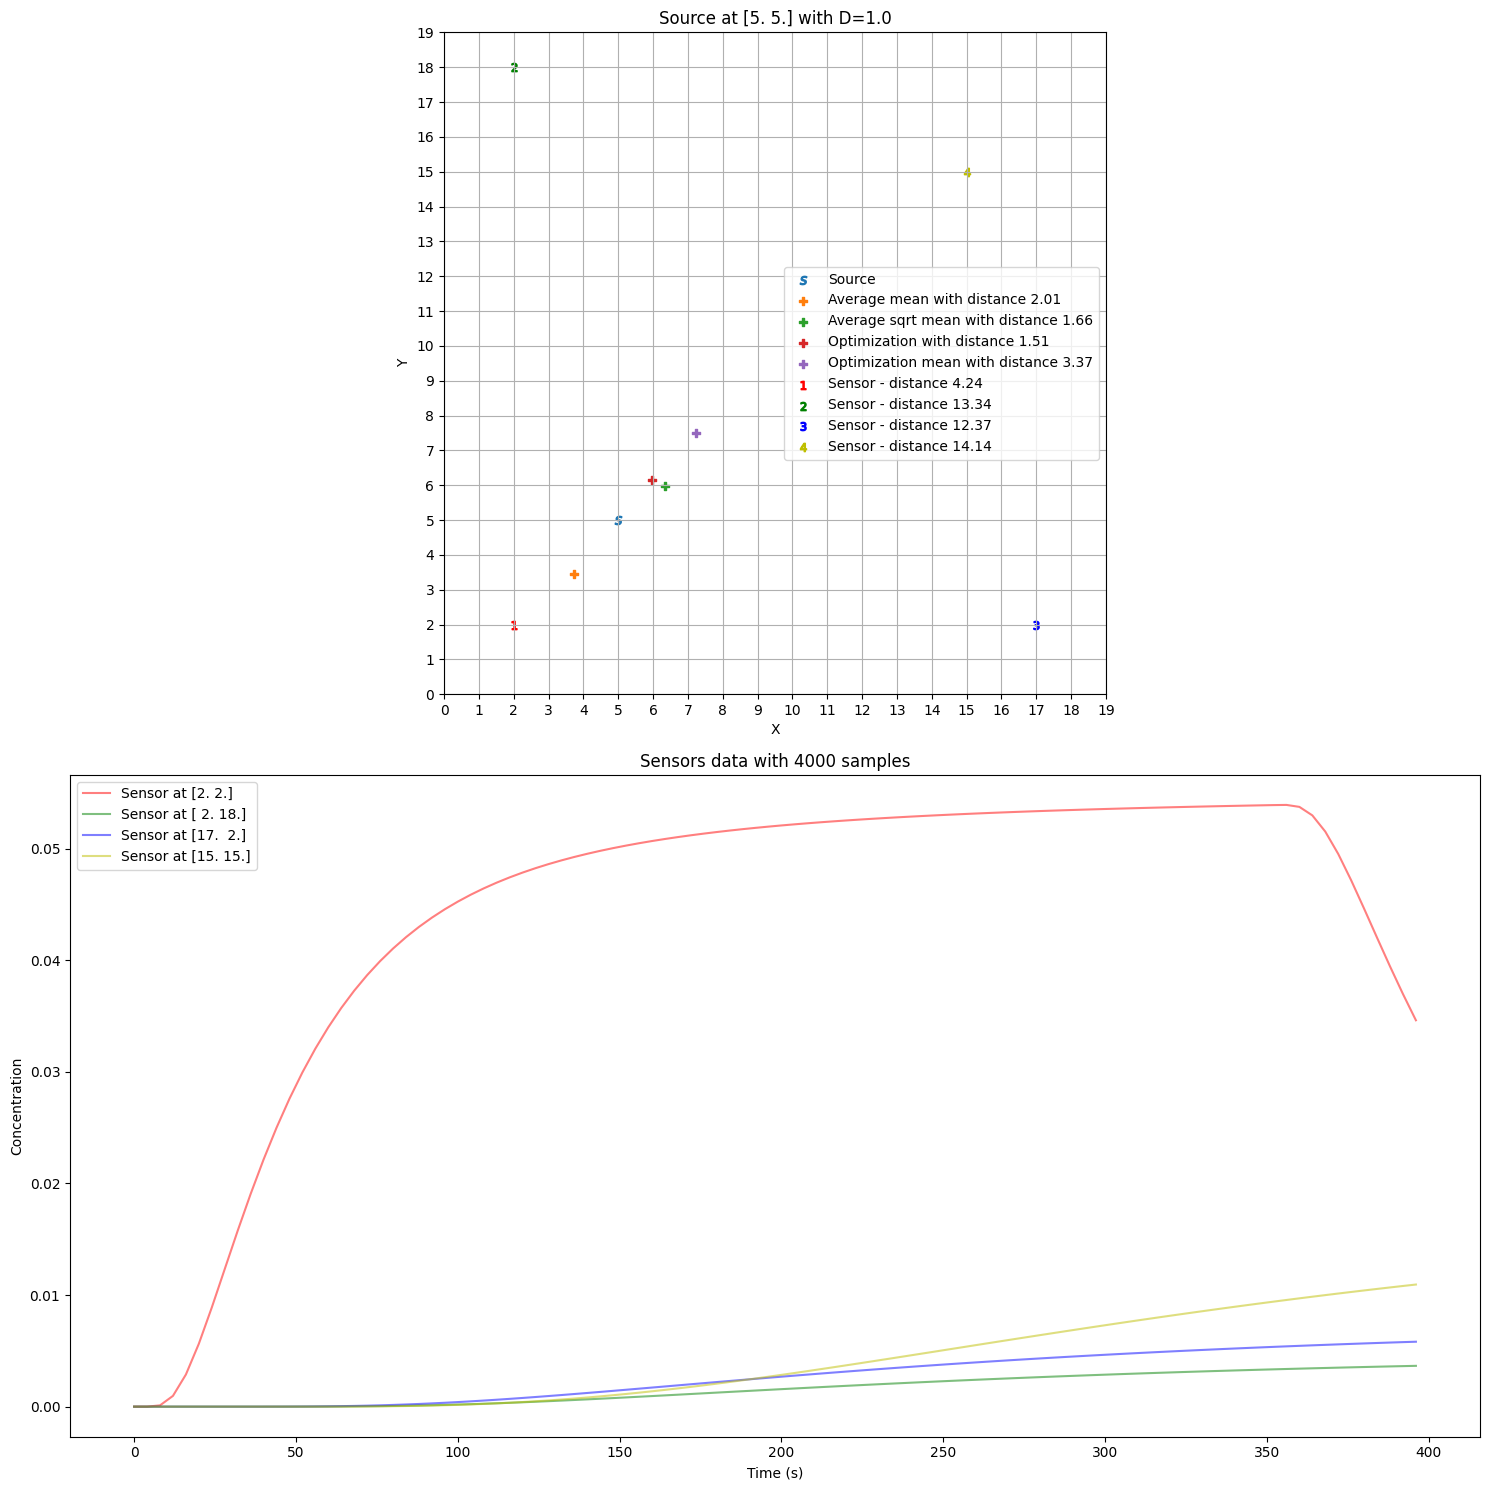

In [227]:
current_environment = raw_training_data[9]


positions = np.array([sensor['real_coordinates'] for sensor in current_environment['sensors']])
grid_positions = np.array([sensor['grid_coordinates'] for sensor in current_environment['sensors']])

values = np.array([sensor['data']['value'] for sensor in current_environment['sensors']])
values_mean = values.mean(axis=1)

distances = np.linalg.norm(positions - current_environment['source_coordinates'], axis=1)



locate_average1 = np.array([locate_average(positions, values[:,i]) for i in range(values.shape[1])])
locate_average_mean = locate_average(positions, values_mean)
locate_average3 = np.array([locate_average(positions, np.sqrt(values[:,i])) for i in range(values.shape[1])])
locate_average_sqrt_mean = locate_average(positions, np.sqrt(values_mean))

predicted_sources_coordinates = {}
combinations_with_replacement
index = 1000


#predicted_sources_coordinates['Average'] = locate_average1[index]
predicted_sources_coordinates['Average mean'] = locate_average_mean
#predicted_sources_coordinates['Average sqrt'] = locate_average3[index]
predicted_sources_coordinates['Average sqrt mean'] = locate_average_sqrt_mean
predicted_sources_coordinates['Optimization'] = locate_optimization2(positions, values[:, index], current_environment['diffusion_coefficient'], index / 10)[0:2]
predicted_sources_coordinates['Optimization mean'] = locate_optimization2(positions, values_mean, current_environment['diffusion_coefficient'], 4000 / 20)[0:2]

#predicted_sources_coordinates['Delaunay sqrt'] = locate_delaunay(positions, np.sqrt(values.mean(axis=1)))
#predicted_sources_coordinates['Delaunay 1/sqrt'] = locate_delaunay(positions, 1/np.sqrt(values.mean(axis=1)))


plot_environment(current_environment, predicted_sources_coordinates)